## Décomposition STL

### Données provenant du collecte du nombre de velos dans certains lieux de Paris
### entre décembre 2024 et janvier 2026

In [14]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

### Importation des données

In [15]:
#!pip install chardet

In [16]:
import chardet
with open("2_comptage-velo.csv","rb") as f:
    raw = f.read(10000)
enc = chardet.detect(raw)['encoding']
df = pd.read_csv("2_comptage-velo.csv", sep=';', encoding=enc)

In [17]:
df.head()

,Identifiant du compteur,Nom du compteur,Identifiant du site de comptage,Nom du site de comptage,Comptage horaire,Date et heure de comptage,Date d'installation du site de comptage,Lien vers photo du site de comptage,Coordonnées géographiques,Identifiant technique compteur,ID Photos,test_lien_vers_photos_du_site_de_comptage_,id_photo_1,url_sites,type_dimage,mois_annee_comptage
0,100044494-353504987,10 avenue de la Grande Armée SE-NO,100044494,10 avenue de la Grande Armée,0,2025-01-07T11:00:00+01:00,07/01/2025,https://filer.eco-counter-tools.com/file/26/1d...,"48.8748, 2.2924",X2H20012081,https://filer.eco-counter-tools.com/file/26/1d...,https://filer.eco-counter-tools.com/file/26/1d...,https:,https://www.eco-visio.net/Photos/100044494,jpg,2025-01
1,100044494-353504987,10 avenue de la Grande Armée SE-NO,100044494,10 avenue de la Grande Armée,54,2025-01-07T14:00:00+01:00,07/01/2025,https://filer.eco-counter-tools.com/file/26/1d...,"48.8748, 2.2924",X2H20012081,https://filer.eco-counter-tools.com/file/26/1d...,https://filer.eco-counter-tools.com/file/26/1d...,https:,https://www.eco-visio.net/Photos/100044494,jpg,2025-01
2,100044494-353504987,10 avenue de la Grande Armée SE-NO,100044494,10 avenue de la Grande Armée,119,2025-01-07T18:00:00+01:00,07/01/2025,https://filer.eco-counter-tools.com/file/26/1d...,"48.8748, 2.2924",X2H20012081,https://filer.eco-counter-tools.com/file/26/1d...,https://filer.eco-counter-tools.com/file/26/1d...,https:,https://www.eco-visio.net/Photos/100044494,jpg,2025-01
3,100044494-353504987,10 avenue de la Grande Armée SE-NO,100044494,10 avenue de la Grande Armée,76,2025-01-07T19:00:00+01:00,07/01/2025,https://filer.eco-counter-tools.com/file/26/1d...,"48.8748, 2.2924",X2H20012081,https://filer.eco-counter-tools.com/file/26/1d...,https://filer.eco-counter-tools.com/file/26/1d...,https:,https://www.eco-visio.net/Photos/100044494,jpg,2025-01
4,100044494-353504987,10 avenue de la Grande Armée SE-NO,100044494,10 avenue de la Grande Armée,47,2025-01-07T20:00:00+01:00,07/01/2025,https://filer.eco-counter-tools.com/file/26/1d...,"48.8748, 2.2924",X2H20012081,https://filer.eco-counter-tools.com/file/26/1d...,https://filer.eco-counter-tools.com/file/26/1d...,https:,https://www.eco-visio.net/Photos/100044494,jpg,2025-01


### Nettoyage des données

#### Selection des colonnes nécessaires

In [18]:
if 'Date et heure de comptage' in df.columns and 'Comptage horaire' in df.columns:
    df_selection = df[['Date et heure de comptage','Comptage horaire']].copy()
    df_selection.columns = ['date','comptage']
else:
    possibles = {col.lower(): col for col in df.columns}
    date_col = possibles.get('date et heure de comptage') or possibles.get('date')
    compt_col = possibles.get('comptage horaire') or possibles.get('comptage')
    if date_col and compt_col:
        df_selection = df[[date_col, compt_col]].copy()
        df_selection.columns = ['date','comptage']
    else:
        raise KeyError('Required columns not found: expected "Date et heure de comptage" and "Comptage horaire"')

df_selection.head()

,date,comptage
0,2025-01-07T11:00:00+01:00,0
1,2025-01-07T14:00:00+01:00,54
2,2025-01-07T18:00:00+01:00,119
3,2025-01-07T19:00:00+01:00,76
4,2025-01-07T20:00:00+01:00,47


#### Modifie du format de la date ( date au lieu de date & heure )

In [19]:
df_selection["date"] = pd.to_datetime(    df_selection["date"],
                                          errors = "coerce", # remplace les valeurs abérrantes par NaN
                                          utc=True # Permet de régler les problèmes de fuseau horaire
                                    )

df_selection['date'] = df_selection["date"].dt.date  
df_selection.head()

,date,comptage
0,2025-01-07,0
1,2025-01-07,54
2,2025-01-07,119
3,2025-01-07,76
4,2025-01-07,47


#### Grouper les comptages par jour et non par heure

In [20]:
import datetime as dt

df_journalier = df_selection.groupby('date')['comptage'].sum().reset_index()
df_journalier = df_journalier[df_journalier["date"] >= dt.date(2025, 1, 7)]

df_journalier.head()




,date,comptage
37,2025-01-07,566
38,2025-01-08,653
39,2025-01-09,809
40,2025-01-10,800
41,2025-01-11,541


## Décomposition de la série

In [21]:
df_journalier.set_index('date', inplace=True)

In [22]:
stl = STL(df_journalier['comptage'], period=365)
result = stl.fit()

In [23]:
trend = result.trend        # Tendance
seasonal = result.seasonal  # Saisonnalité
residual = result.resid      # Résidus


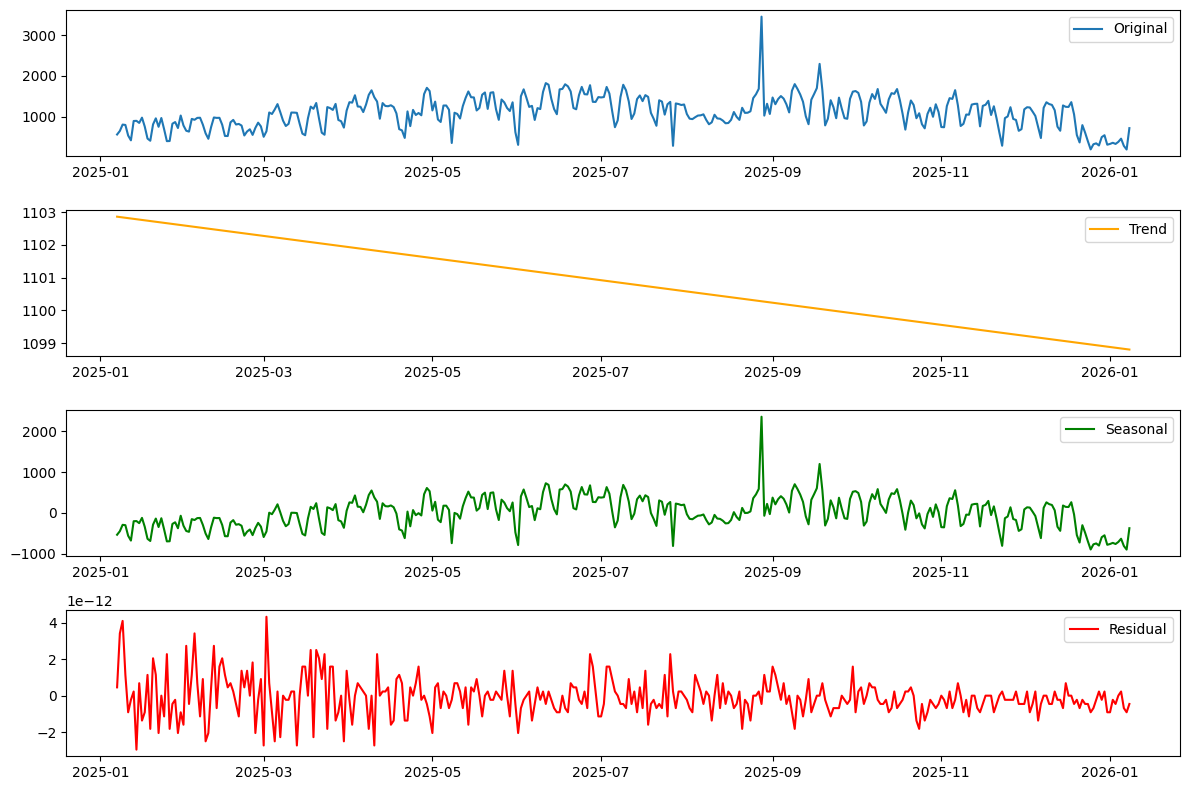

In [24]:

plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(df_journalier['comptage'], label='Original')
plt.legend()

plt.subplot(4,1,2)
plt.plot(trend, label='Trend', color='orange')
plt.legend()

plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend()

plt.subplot(4,1,4)
plt.plot(residual, label='Residual', color='red')
plt.legend()

plt.tight_layout()
plt.show()
